# 0. 준비 단계

## 패키지 설치 & 버전 확인

In [ ]:
!pip -q install torch sentencepiece sacrebleu tqdm PyYAML

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.8/51.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.1/104.1 kB 7.5 MB/s eta 0:00:00


In [ ]:
import torch, platform
print("PyTorch:", torch.__version__)
print("Python:", platform.python_version())
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))

PyTorch: 2.8.0+cu126
Python: 3.12.12
CUDA available: True
GPU name: NVIDIA L4


## 폴더 구조 설정

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from pathlib import Path
import torch, random, numpy as np
BASE = Path('/content/drive/MyDrive/서울대/snuann/Transform')  # 기본 폴더명 설정 필요
DATA_DIR = BASE / "data"
RAW_DIR  = DATA_DIR / "raw"
SPM_DIR  = DATA_DIR / "spm"
CACHE_DIR = DATA_DIR / "cache"
CKPT_DIR = BASE / "ckpt"
RUNS_DIR = BASE / "runs"
OUT_DEC_DIR = BASE / "outputs" / "decode"
OUT_EVAL_DIR = BASE / "outputs" / "eval"

for p in [RAW_DIR, SPM_DIR, CACHE_DIR, CKPT_DIR, RUNS_DIR, OUT_DEC_DIR, OUT_EVAL_DIR]:
    p.mkdir(parents=True, exist_ok=True)

# 재현성 시드 & 디바이스
def set_seed(seed: int = 42):
    random.seed(seed); np.random.seed(seed)
    torch.manual_seed(seed); torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
SEED = 42
set_seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("BASE        :", BASE.resolve())
print("DATA/raw    :", RAW_DIR.resolve())
print("DATA/spm    :", SPM_DIR.resolve())
print("CKPT        :", CKPT_DIR.resolve())
print("DEVICE      :", DEVICE)

BASE        : /content/drive/MyDrive/서울대/snuann/Transform
DATA/raw    : /content/drive/MyDrive/서울대/snuann/Transform/data/raw
DATA/spm    : /content/drive/MyDrive/서울대/snuann/Transform/data/spm
CKPT        : /content/drive/MyDrive/서울대/snuann/Transform/ckpt
DEVICE      : cuda


## Tokenizer 준비

In [ ]:
# === SentencePiece 공용 BPE 학습 ===
import sentencepiece as spm

SPM_MODEL = SPM_DIR / "spm.model"
SPM_VOCAB = SPM_DIR / "spm.vocab"
INPUT_EN = RAW_DIR / "train.en" # 별도 파일에서 생성
INPUT_KO = RAW_DIR / "train.ko" # 각 문장이 대응되며 한 줄씩 쓰여져 있는 형태

PAD_ID = 0
BOS_ID = 1
EOS_ID = 2
UNK_ID = 3

if not SPM_MODEL.exists():
    arg_str = " ".join([
        f"--input={INPUT_EN},{INPUT_KO}",
        f"--model_prefix={SPM_DIR/'spm'}",    # 모델 저장 경로
        "--model_type=bpe",
        "--vocab_size=16000",                 # 필요시 8k~32k로 조절
        "--character_coverage=0.9995",
        "--normalization_rule_name=nmt_nfkc", # 유니코드 정규화
        "--byte_fallback=true",               # 희귀 문자 안전 처리(OOV 방지)
        "--input_sentence_size=10000000",
        "--shuffle_input_sentence=true",
        f"--pad_id={PAD_ID}", # Padding Token
        f"--bos_id={BOS_ID}", # 시작 Token
        f"--eos_id={EOS_ID}", # 끝 Token
        f"--unk_id={UNK_ID}"
    ])
    spm.SentencePieceTrainer.Train(arg_str)
    print("SPM trained:", SPM_MODEL)
else:
    print("SPM exists:", SPM_MODEL)


SPM exists: /content/drive/MyDrive/서울대/snuann/Transform/data/spm/spm.model


In [ ]:
# === 간단 래퍼 & 스모크 테스트 ===
class SPMTokenizer:
    def __init__(self, model_path):
        self.sp = spm.SentencePieceProcessor()
        self.sp.load(str(model_path))
    def encode(self, text):
        return self.sp.encode(text, out_type=int)
    def decode(self, ids):
        # 우리가 붙인 특수토큰은 제거하고 복원
        ids = [i for i in ids if i not in (PAD_ID, BOS_ID, EOS_ID)]
        return self.sp.decode(ids)
    @property
    def vocab_size(self):
        return self.sp.get_piece_size()

tok = SPMTokenizer(SPM_MODEL)
print("vocab_size:", tok.vocab_size)

# 샘플 인코딩/디코딩 확인
sample_en = "This is a small tokenizer test."
sample_ko = "이것은 작은 토크나이저 테스트입니다."
en_ids = [BOS_ID] + tok.encode(sample_en) + [EOS_ID]
ko_ids = [BOS_ID] + tok.encode(sample_ko) + [EOS_ID]
print("EN ids (head):", en_ids[:12], "... len=", len(en_ids))
print("KO ids (head):", ko_ids[:12], "... len=", len(ko_ids))
print("EN decoded:", tok.decode(en_ids))
print("KO decoded:", tok.decode(ko_ids))

vocab_size: 16000
EN ids (head): [1, 974, 312, 262, 1675, 290, 14914, 272, 477, 268, 2299, 14900] ... len= 13
KO ids (head): [1, 5682, 4880, 1767, 15178, 14954, 14904, 15096, 10273, 955, 14900, 2] ... len= 12
EN decoded: This is a small tokenizer test.
KO decoded: 이것은 작은 토크나이저 테스트입니다.


# 1. 데이터 로드 & 모델 생성

## Dataset 준비

In [ ]:
# # === Token length distribution for En↔Ko with your SentencePiece ===
# # - 입력: data/raw/train.en, data/raw/train.ko, data/spm/spm.model
# # - 출력: 길이 통계(퍼센타일) + 히스토그램 + 권장 max_src_len/max_tgt_len

# from pathlib import Path
# import math
# import numpy as np
# import matplotlib.pyplot as plt
# import sentencepiece as spm

# # ---- 옵션 ----
# ADD_BOS_EOS = True      # BOS/EOS 붙였을 때 길이도 함께 리포팅
# SAMPLE_MAX = None       # 샘플링 개수 제한. None=전체, 예: 200000
# BINS = 80               # 히스토그램 bin 수
# PERCENTILES = [50, 90, 95, 98, 99, 100]

# assert INPUT_EN.exists() and INPUT_KO.exists(), "train.en / train.ko 파일이 필요합니다."
# assert SPM_MODEL.exists(), "SentencePiece 모델(spm.model)을 먼저 학습해 주세요."

# sp = spm.SentencePieceProcessor()
# sp.load(str(SPM_MODEL))

# def iter_lines(path, limit=None):
#     with open(path, encoding="utf-8") as f:
#         for i, line in enumerate(f):
#             if limit is not None and i >= limit:
#                 break
#             yield line.strip()

# def token_lengths(path):
#     lens_no_special = []
#     lens_with_special = []
#     for s in iter_lines(path, limit=SAMPLE_MAX):
#         ids = sp.encode(s, out_type=int)
#         lens_no_special.append(len(ids))
#         if ADD_BOS_EOS:
#             lens_with_special.append(len(ids) + 2)  # BOS+EOS
#     a_no = np.array(lens_no_special, dtype=np.int32)
#     a_with = np.array(lens_with_special, dtype=np.int32) if ADD_BOS_EOS else None
#     return a_no, a_with

# en_no, en_with = token_lengths(INPUT_EN)
# ko_no, ko_with = token_lengths(INPUT_KO)

# def describe(arr):
#     arr = np.asarray(arr, dtype=np.int32)
#     stats = {
#         "min": int(arr.min()), "mean": float(arr.mean()),
#         "std": float(arr.std()), "max": int(arr.max())
#     }
#     for p in PERCENTILES:
#         stats[f"p{p}"] = float(np.percentile(arr, p if p < 100 else 100))
#     return stats

# en_stats_no = describe(en_no)
# ko_stats_no = describe(ko_no)
# en_stats_with = describe(en_with) if ADD_BOS_EOS else None
# ko_stats_with = describe(ko_with) if ADD_BOS_EOS else None

# def suggest_max_len(stats):
#     # p98 근처를 권장 상한으로. 8 단위 올림(패딩/버킷팅에 유리)
#     return int(math.ceil(stats["p98"] / 8.0) * 8)

# suggest_src = suggest_max_len(en_stats_with if ADD_BOS_EOS else en_stats_no)
# suggest_tgt = suggest_max_len(ko_stats_with if ADD_BOS_EOS else ko_stats_no)

# print("=== EN (source) lengths — WITHOUT specials ===")
# print(en_stats_no)
# print("\n=== KO (target) lengths — WITHOUT specials ===")
# print(ko_stats_no)
# if ADD_BOS_EOS:
#     print("\n=== EN (source) lengths — WITH BOS/EOS ===")
#     print(en_stats_with)
#     print("\n=== KO (target) lengths — WITH BOS/EOS ===")
#     print(ko_stats_with)

# print("\n=== Suggested max lengths (≈ p98, rounded to /8) ===")
# print(f"max_src_len ≈ {suggest_src}")
# print(f"max_tgt_len ≈ {suggest_tgt}")

# # ---- Histograms ----
# plt.figure(figsize=(7,4))
# plt.hist(en_with if ADD_BOS_EOS else en_no, bins=BINS)
# plt.title("EN token length distribution (with BOS/EOS)" if ADD_BOS_EOS else "EN token length distribution")
# plt.xlabel("tokens"); plt.ylabel("sentences")
# plt.show()

# plt.figure(figsize=(7,4))
# plt.hist(ko_with if ADD_BOS_EOS else ko_no, bins=BINS)
# plt.title("KO token length distribution (with BOS/EOS)" if ADD_BOS_EOS else "KO token length distribution")
# plt.xlabel("tokens"); plt.ylabel("sentences")
# plt.show()

# # ---- CDF (누적분포) ----
# plt.figure(figsize=(7,4))
# vals = np.sort(en_no); y = np.arange(1, len(vals)+1) / len(vals)
# plt.plot(vals, y, label="EN (no specials)")
# if ADD_BOS_EOS:
#     vals2 = np.sort(en_with); y2 = np.arange(1, len(vals2)+1) / len(vals2)
#     plt.plot(vals2, y2, label="EN (with BOS/EOS)")
# plt.title("EN token length CDF"); plt.xlabel("tokens"); plt.ylabel("cdf"); plt.legend()
# plt.show()

# plt.figure(figsize=(7,4))
# vals = np.sort(ko_no); y = np.arange(1, len(vals)+1) / len(vals)
# plt.plot(vals, y, label="KO (no specials)")
# if ADD_BOS_EOS:
#     vals2 = np.sort(ko_with); y2 = np.arange(1, len(vals2)+1) / len(vals2)
#     plt.plot(vals2, y2, label="KO (with BOS/EOS)")
# plt.title("KO token length CDF"); plt.xlabel("tokens"); plt.ylabel("cdf"); plt.legend()
# plt.show()


In [ ]:
# 필요 모듈
import torch, math, re
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import sentencepiece as spm
from pathlib import Path

# ===== 토크나이저 래퍼 =====
SPM_MODEL = (SPM_DIR / "spm.model")
sp = spm.SentencePieceProcessor(); sp.load(str(SPM_MODEL))

def sp_encode(text):  # SPM encode (BOS/EOS는 여기서 붙이지 않음)
    return sp.encode(text, out_type=int)

def sp_decode(ids):  # 안전하게 특수토큰 제거 후 디코드
    ids = [i for i in ids if i not in (PAD_ID, BOS_ID, EOS_ID)]
    return sp.decode(ids)

# ===== Dataset =====
class ParallelText(Dataset):
    def __init__(self, en_path, ko_path, max_src_len=96, max_tgt_len=80):
        self.en_lines = [l.rstrip("\n") for l in open(en_path, encoding="utf-8")]
        self.ko_lines = [l.rstrip("\n") for l in open(ko_path, encoding="utf-8")]
        assert len(self.en_lines) == len(self.ko_lines), "en/ko line counts must match"
        self.max_src_len = max_src_len
        self.max_tgt_len = max_tgt_len

    def __len__(self): return len(self.en_lines)

    def __getitem__(self, i):
        src_ids = [BOS_ID] + sp_encode(self.en_lines[i])[:self.max_src_len-2] + [EOS_ID]
        tgt_ids = [BOS_ID] + sp_encode(self.ko_lines[i])[:self.max_tgt_len-2] + [EOS_ID]
        return {"src": torch.tensor(src_ids, dtype=torch.long),
                "tgt": torch.tensor(tgt_ids, dtype=torch.long)}

# ===== 마스크 유틸 (True == mask) =====
def make_padding_mask(lengths, max_len, device=None):
    rng = torch.arange(max_len, device=device).unsqueeze(0)        # [1,T]
    return rng >= lengths.unsqueeze(1)                              # [B,T]  True at PAD

def make_causal_mask(T, device=None):
    i = torch.arange(T, device=device).unsqueeze(1)                 # [T,1]
    j = torch.arange(T, device=device).unsqueeze(0)                 # [1,T]
    return j > i                                                    # [T,T]  upper-tri True

# ===== Collate: 패딩 & 마스크 & 디코더 입출 분리 =====
def collate_fn(batch):
    B = len(batch)
    device = torch.device("cpu")

    src_lens = torch.tensor([len(x["src"]) for x in batch])
    tgt_lens = torch.tensor([len(x["tgt"]) for x in batch])
    S, T = int(src_lens.max()), int(tgt_lens.max())

    src_ids = torch.full((B, S), PAD_ID, dtype=torch.long)
    tgt_ids = torch.full((B, T), PAD_ID, dtype=torch.long)
    for i, x in enumerate(batch):
        src_ids[i, :len(x["src"])] = x["src"]
        tgt_ids[i, :len(x["tgt"])] = x["tgt"]

    # 디코더 입력/라벨
    tgt_in  = tgt_ids[:, :-1]              # [B, T-1]  (BOS 포함, 마지막 제거)
    tgt_out = tgt_ids[:, 1:]               # [B, T-1]  (첫 토큰 제거, EOS 포함)

    # 마스크(True==mask)
    src_pad  = make_padding_mask(src_lens, S, device=device)        # [B,S]
    tgt_pad  = make_padding_mask(tgt_lens, T, device=device)        # [B,T]
    causal   = make_causal_mask(T-1, device=device)                 # [T-1, T-1]

    src_mask = src_pad.unsqueeze(1).unsqueeze(2)                    # [B,1,1,S]
    tgt_mask = (tgt_pad[:, :-1].unsqueeze(1).unsqueeze(2) |
                causal.unsqueeze(0).unsqueeze(1))                   # [B,1,T-1,T-1]
    mem_mask = src_pad.unsqueeze(1).unsqueeze(2).expand(B,1,T-1,S)  # [B,1,T-1,S]

    return {
        "src_ids": src_ids, "tgt_ids": tgt_ids,
        "tgt_in": tgt_in, "tgt_out": tgt_out,
        "src_lens": src_lens, "tgt_lens": tgt_lens,
        "src_mask": src_mask, "tgt_mask": tgt_mask, "mem_mask": mem_mask,
    }

# ===== DataLoader 만들기 & 스모크 테스트 =====
EN_TRAIN_PATH = RAW_DIR / "train.en"
KO_TRAIN_PATH = RAW_DIR / "train.ko"
max_src_len, max_tgt_len = 96, 80
batch_size = 64
valid_ratio = 0.2

# 재현성을 위함
def _worker_init_fn(worker_id):
    worker_seed = SEED + worker_id
    np.random.seed(worker_seed); random.seed(worker_seed); torch.manual_seed(worker_seed)

torch_dl_generator = torch.Generator()
torch_dl_generator.manual_seed(SEED)

dataset = ParallelText(EN_TRAIN_PATH, KO_TRAIN_PATH, max_src_len, max_tgt_len)
n_total = len(dataset)
n_valid = int(n_total * valid_ratio)
n_train = n_total - n_valid
train_ds, valid_ds = random_split(dataset, [n_train, n_valid])
train_dl = DataLoader(
    train_ds, batch_size=64, shuffle=True,
    worker_init_fn=_worker_init_fn,
    generator=torch_dl_generator,
    collate_fn=collate_fn
)
valid_dl = DataLoader(
    valid_ds, batch_size=64, shuffle=False,
    worker_init_fn=_worker_init_fn,
    generator=torch_dl_generator,
    collate_fn=collate_fn
)

batch = next(iter(train_dl))
for k, v in batch.items():
    if torch.is_tensor(v):
        print(f"{k:9s}", tuple(v.shape), v.dtype)


src_ids   (64, 66) torch.int64
tgt_ids   (64, 69) torch.int64
tgt_in    (64, 68) torch.int64
tgt_out   (64, 68) torch.int64
src_lens  (64,) torch.int64
tgt_lens  (64,) torch.int64
src_mask  (64, 1, 1, 66) torch.bool
tgt_mask  (64, 1, 68, 68) torch.bool
mem_mask  (64, 1, 68, 66) torch.bool


## 모델 구축

### Positional Encoding

In [ ]:
class SinePositionalEncoding(nn.Module):
    def __init__(self, d_model, n_tokens = 100):
        '''
        d_model: 하나의 단어를 표현하는 임베딩 벡터의 길이
        n_tokens: 가능한 최대 토큰의 수
        register_buffer : parameter가 아닌 고정된 값으로써 모델에 저장하는 것, 이후에 load로 모델을 불러올 떄도 불러와짐
        '''
        super().__init__()
        self.register_buffer('pos_table', self._get_encoding_table(d_model, n_tokens)) # pos_table이라는 속성에 저장하는 것

    def _get_encoding_table(self, d_model, n_tokens):
        def _get_position_vector(pos):
            return np.array([pos / np.power(10000, 2*(i//2) / d_model) for i in range(d_model)])

        sinusoid_table = np.array([_get_position_vector(pos) for pos in range(n_tokens)]) # (n_tokens, d_model)
        sinusoid_table[:, 0::2] = np.sin(sinusoid_table[:, 0::2])
        sinusoid_table[:, 1::2] = np.cos(sinusoid_table[:, 1::2])

        return torch.FloatTensor(sinusoid_table).unsqueeze(0)        # (1, n_tokens, d_model)

    def forward(self, x):                                            # x : (B, T, d_model), T : 문장 내에서 토큰의 개수
        return x + self.pos_table[:,:x.size(1),:].clone().detach()   # (1, T, d_model)로 바뀌어서 BroadCasting됨
                                                                     # (참고) detach()는 grad 계산 대상에서 제외하기 위함. 사실 이미 register_buffer로 처리가 되있어서 이중 방어? 인 셈


### Scaled Dot-Product Attention

In [ ]:
class ScaledDotProductAttention(nn.Module):
    def __init__(self, d_k, attn_dropout = 0.1):
        '''
        d_k = d_model / H (H : head 개수) -> 가중치로 사용
        '''
        super().__init__()
        self.temperature = np.sqrt(d_k)
        self.dropout = nn.Dropout(attn_dropout)

    def forward(self, q, k, v, mask = None):
        '''
        q : (B, H, Tq, d_k)
        k : (B, H, Tk, d_k)
        v : (B, H, Tk, d_v) (d_v = d_k) (모든 경우에서 Key와 Value는 같은 종류이므로 Token의 최대 개수가 Tk로 동일)
        mask : (B, 1, Tq, Tk)
        '''
        attn = torch.matmul(q, k.transpose(2,3)) / self.temperature # (B, H, Tq, Tk)

        if mask is not None:
            attn = attn.masked_fill(mask, float('-inf')) # mask에서 True인 값은 가중치를 매우 작게 주어 Attention 가중치에 영향 안 주도록 함

        attn = self.dropout(F.softmax(attn, dim=-1))

        output = torch.matmul(attn, v) # (B, H, Tq, d_v)
        return output, attn

### Multi-Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, n_head, d_model, d_k, d_v, dropout = 0.1):
        super().__init__()

        self.n_head = n_head # H
        self.d_k = d_k
        self.d_v = d_v

        assert d_model % n_head == 0, "d_model must be divisible by n_head"

        self.w_q = nn.Linear(d_model, n_head * d_k, bias = False)
        self.w_k = nn.Linear(d_model, n_head * d_k, bias = False)
        self.w_v = nn.Linear(d_model, n_head * d_v, bias = False)
        self.fc = nn.Linear(n_head * d_v, d_model, bias = False)

        self.attention = ScaledDotProductAttention(d_k)
        self.dropout = nn.Dropout(dropout)

    def forward(self, q, k, v, mask = None):
        '''
        q : (B, Tq, d_model)
        k : (B, Tk, d_model)
        v : (B, Tk, d_model)
        mask : (B, 1, Tq, Tk)
        '''

        d_k, d_v, n_head = self.d_k, self.d_v, self.n_head
        B, len_q, len_k, len_v = q.size(0), q.size(1), k.size(1), v.size(1) # B, Tq, Tk, Tk

        q = self.w_q(q).view(B, len_q, n_head, d_k).transpose(1,2) # (B, H, Tq, d_k)
        k = self.w_k(k).view(B, len_k, n_head, d_k).transpose(1,2) # (B, H, Tk, d_k)
        v = self.w_v(v).view(B, len_v, n_head, d_v).transpose(1,2) # (B, H, Tk, d_v)

        out, attn = self.attention(q, k, v, mask = mask)             # (B, H, Tq, d_v), (B, H, Tq, Tk)

        q = out.transpose(1,2).reshape(B, len_q, -1)                 # (B, Tq, H * d_v) / .contiguous().view(B, len_q, -1)은 좀 더 안전한 버전
        q = self.dropout(self.fc(q))                               # (B, Tq, d_model) -> multi-head attention을 통해 q의 새로운 embedding vector를 얻어낸 것

        return q, attn



### Position-wise FFN

In [ ]:
class PositionWiseFFN(nn.Module): # FFN + Residual Connect + LayerNorm
    def __init__(self, d_in, d_hid, dropout = 0.1):
        super().__init__()
        self.w_1 = nn.Linear(d_in, d_hid)
        self.w_2 = nn.Linear(d_hid, d_in)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        # x의 마지막 차원: d_model, 즉, 각 단어별로 임베딩 벡터를 FFN을 통해 변환하는 과정
        x = self.w_2(self.dropout(F.relu(self.w_1(x))))

        return x

### Encoder Layer (Pre-LN)

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, d_hid, n_head, d_k, d_v, dropout = 0.1):
        super().__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout = dropout)
        self.FFN = PositionWiseFFN(d_model, d_hid, dropout = dropout)
        self.layer_norm1 = nn.LayerNorm(d_model, eps = 1e-6)
        self.layer_norm2 = nn.LayerNorm(d_model, eps = 1e-6)
        self.drop = nn.Dropout(dropout)


    def forward(self, enc_input, src_mask = None):
        '''
        enc_input : (B, S, d_model)
        src_mask : (B, 1, 1, S)
        enc_output : (B, S, d_model)

        기존 논문 : SubLayer -> Residual -> LayerNorm
        Pre-LN    : LayerNorm -> SubLayer -> Residual
        여기서 SubLayer는 Multi-Head Attention과 Position-wise FFN

        Multi-Head Attention은 Q, K, V를 모두 enc_input으로 사용한 Self-Attention
        '''
        # Self-Attention
        residual = enc_input
        x = self.layer_norm1(enc_input) # (B, S, d_model)
        y, enc_slf_attn = self.slf_attn(x, x, x, mask = src_mask)
        y = self.drop(y) + residual

        # Position-Wise FFN
        residual = y
        y = self.layer_norm2(y)
        enc_output = self.FFN(y)
        enc_output = self.drop(enc_output) + residual

        return enc_output, enc_slf_attn

### Decoder Layer (Pre-LN)

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_hid, n_head, d_k, d_v, dropout = 0.1):
        super().__init__()
        self.slf_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout = dropout)
        self.dec_enc_attn = MultiHeadAttention(n_head, d_model, d_k, d_v, dropout = dropout)
        self.FFN = PositionWiseFFN(d_model, d_hid, dropout = dropout)

        self.layer_norm1 = nn.LayerNorm(d_model, eps = 1e-6)
        self.layer_norm2 = nn.LayerNorm(d_model, eps = 1e-6)
        self.layer_norm3 = nn.LayerNorm(d_model, eps = 1e-6)

        self.dropout = nn.Dropout(dropout)

    def forward(self, dec_input, enc_output, tgt_mask = None, mem_mask = None):
        '''
        dec_input : (B, T-1, d_model)
        enc_output : (B, S, d_model)
        tgt_mask : (B, 1, T-1, T-1)
        mem_mask : (B, 1, T-1, S)

        Pre-LN 방식은 마찬가지
        여기서 Sublayer 흐름은 Self Attention (MultiHeadAttention) -> Encoder-Decoder Attention (MultiHeadAttention) -> Position-Wise FFN

        Self-Attention의 Q, K, V는 모두 dec_input
        Encoder-Decoder Attention의 Q는 Self-Attention을 거친 dec_input, K, V는 enc-output (Encoder의 최종 Embedding Vector)
        '''
        # Self-Attention
        residual = dec_input
        x = self.layer_norm1(dec_input)
        y, dec_slf_attn = self.slf_attn(x, x, x, mask = tgt_mask)
        y = self.dropout(y) + residual

        # Encoder-Decoder Attention
        residual = y
        y = self.layer_norm2(y)
        z, dec_enc_attn = self.dec_enc_attn(y, enc_output, enc_output, mask = mem_mask)
        z = self.dropout(z) + residual

        # Position-Wise FFN
        residual = z
        z = self.layer_norm3(z)
        dec_output = self.FFN(z)
        dec_output = self.dropout(dec_output) + residual

        return dec_output, dec_slf_attn, dec_enc_attn



### Encoder

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_src_vocab, d_word_vec, n_layers, d_model, d_hid,
                 n_head, d_k, d_v, pad_idx, dropout = 0.1, n_tokens = 100, scale_emb = False):
        '''
        n_src_vocab : BPE 과정을 통해 생성된 Token의 총 개수 (source, 우리 코드에서는 영어)
        d_word_vec : 임베딩 벡터의 차원 (보통 d_model과 동일)
        n_layers : Encoder Layer의 개수
        d_model : 각 단어별 임베딩 벡터의 차원
        d_hid : FFN에서 사용되는 내부 벡터 차원
        n_head : Multi-Head Attention에서 Head의 개수
        d_k : Multi-Head Attention에서 Query, Key가 압축되는 벡터의 차원
        d_v : Multi-Head Attention에서 Value가 압축되는 벡터의 차원
        pad_idx : Padding Token의 인덱스 (우리 코드에서는 0)
        dropout : Dropout 비율
        n_tokens : 한 문장 내에서 Token의 최대 개수 (1 + 96 + 1인데 널널하게 100으로 잡음)
        scale_emb : 단어 Embedding시 스케일링 여부
        '''

        super().__init__()
        assert d_model == d_word_vec, "d_model must be equal to d_word_vec"
        self.src_word_emb = nn.Embedding(n_src_vocab, d_word_vec, padding_idx = pad_idx) # 각 Token을 Embedding Vector로 바꾸는 신경망
        self.position_enc = SinePositionalEncoding(d_model, n_tokens = n_tokens)
        self.dropout = nn.Dropout(dropout)
        self.layer_stack = nn.ModuleList([
            EncoderLayer(d_model, d_hid, n_head, d_k, d_v, dropout = dropout)
                                         for _ in range(n_layers)])
        self.final_layer_norm = nn.LayerNorm(d_model, eps = 1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, src_seq, src_mask, return_attns = False):
        '''
        src_seq : (B, S), Index 형태로 저장된 Token 리스트
        src_mask : (B, 1, 1, S)
        enc_output : (B, S, d_model)
        '''

        enc_slf_attn_list = [] # attention 결과를 저장할 리스트

        # 각 토큰을 Embedding Vector로 반환
        enc_output = self.src_word_emb(src_seq) # (B, S) -> (B, S, d_word_vec = d_model)
        if self.scale_emb:
            enc_output *= self.d_model ** 0.5
        enc_output = self.dropout(self.position_enc(enc_output)) # Positional Encoding 추가

        for enc_layer in self.layer_stack:
            enc_output, enc_slf_attn = enc_layer(enc_output, src_mask)
            enc_slf_attn_list += [enc_slf_attn] if return_attns else []
        enc_output = self.final_layer_norm(enc_output)

        if return_attns:
            return enc_output, enc_slf_attn_list
        return enc_output, None



### Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, n_tgt_vocab, d_word_vec, n_layers, d_model, d_hid,
                 n_head, d_k, d_v, pad_idx, dropout = 0.1, n_tokens = 100, scale_emb = False):
        '''
        n_tgt_vocab : BPE 과정을 통해 생성된 Token의 총 개수 (Target, 우리 코드에서는 한국어)
        d_word_vec : 임베딩 벡터의 차원 (보통 d_model과 동일)
        n_layers : Decoder Layer의 개수
        d_model : 각 단어별 임베딩 벡터의 차원
        d_hid : FFN에서 사용되는 내부 벡터 차원
        n_head : Multi-Head Attention에서 Head의 개수
        d_k : Multi-Head Attention에서 Query, Key가 압축되는 벡터의 차원
        d_v : Multi-Head Attention에서 Value가 압축되는 벡터의 차원
        pad_idx : Padding Token의 인덱스 (우리 코드에서는 0)
        dropout : Dropout 비율
        n_tokens : 한 문장 내에서 Token의 최대 개수 (1 + 96 + 1인데 널널하게 100으로 잡음)
        scale_emb : 단어 Embedding시 스케일링 여부
        '''

        super().__init__()
        assert d_model == d_word_vec, "d_model must be equal to d_word_vec"
        self.tgt_word_emb = nn.Embedding(n_tgt_vocab, d_word_vec, padding_idx = pad_idx) # 각 Token을 Embedding Vector로 바꾸는 신경망
        self.position_enc = SinePositionalEncoding(d_model, n_tokens = n_tokens)
        self.dropout = nn.Dropout(dropout)
        self.layer_stack = nn.ModuleList([
            DecoderLayer(d_model, d_hid, n_head, d_k, d_v, dropout = dropout)
                                         for _ in range(n_layers)])
        self.final_layer_norm = nn.LayerNorm(d_model, eps = 1e-6)
        self.scale_emb = scale_emb
        self.d_model = d_model

    def forward(self, tgt_seq, tgt_mask, enc_output, mem_mask, return_attns = False):
        '''
        tgt_seq : (B, T-1), Index 형태로 저장된 Token 리스트
        tgt_mask : (B, 1, T-1, T-1)
        mem_mask : (B, 1, T-1, S)
        dec_output : (B, T-1, d_model)
        '''

        dec_slf_attn_list, dec_enc_attn_list = [], [] # attention 결과를 저장할 리스트

        # 각 토큰을 Embedding Vector로 반환
        dec_output = self.tgt_word_emb(tgt_seq) # (B, S) -> (B, S, d_word_vec = d_model)
        if self.scale_emb:
            dec_output *= self.d_model ** 0.5
        dec_output = self.dropout(self.position_enc(dec_output)) # Positional decoding 추가

        for dec_layer in self.layer_stack:
            dec_output, dec_slf_attn, dec_enc_attn = dec_layer(dec_output, enc_output, tgt_mask = tgt_mask, mem_mask = mem_mask)
            dec_slf_attn_list += [dec_slf_attn] if return_attns else []
            dec_enc_attn_list += [dec_enc_attn] if return_attns else []
        dec_output = self.final_layer_norm(dec_output)
        if return_attns:
            return dec_output, dec_slf_attn_list, dec_enc_attn_list
        return dec_output, None, None



### Transformer

In [ ]:
class Transformer(nn.Module):
    def __init__(self, n_src_vocab, n_tgt_vocab, pad_idx,
                 d_word_vec = 512, d_model = 512, d_hid = 2048, n_layers = 6,
                 n_head = 8, d_k = 64, d_v = 64, dropout = 0.1, n_tokens = 100,
                 tgt_emb_prj_weight_sharing = True, emb_src_tgt_weight_sharing = True,
                 scale_emb_or_prj = "prj"):
        '''
        tgt_emb_prj_weight_sharing :
        Decoder 첫 부분의 Embedding Layer의 가중치와
        디코더 마지막의 최종 출력 벡터를 전체 어휘 크기의 벡터로 바꾸는 과정 (Projection)의 가중치를 공유할 지 여부
        즉, (단어 -> 벡터) 과정과 (벡터 -> 단어) 과정의 가중치를 공유하는 것

        emb_src_tgt_weight_sharing:
        Source Embedding Layer와 Target Embedding Layer의 가중치 공유 여부
        Source와 Target의 언어가 같은 때 사용 (두 언어가 다르더라도 embedding 공간을 공유하고 있다면 사용 가능함)

        scale_emb_or_prj : Scaling을 embedding을 만드는 과정에서 할 지, 마지막 Projection 과정에서 할 지 여부
        #   'emb': multiply \sqrt{d_model} to embedding output
        #   'prj': multiply (\sqrt{d_model} ^ -1) to linear projection output
        #   'none': no multiplication
        '''

        super().__init__()

        self.pad_idx = pad_idx

        assert scale_emb_or_prj in ['emb', 'prj', 'none']
        scale_emb = (scale_emb_or_prj == 'emb') if tgt_emb_prj_weight_sharing else False
        self.scale_prj = (scale_emb_or_prj == 'prj') if tgt_emb_prj_weight_sharing else False
        self.d_model = d_model

        self.encoder = Encoder(n_src_vocab = n_src_vocab, d_word_vec = d_word_vec, n_layers = n_layers,
                               d_model = d_model, d_hid = d_hid, n_head = n_head, d_k = d_k, d_v = d_v,
                               pad_idx = pad_idx, dropout = dropout, n_tokens = n_tokens, scale_emb = scale_emb)

        self.decoder = Decoder(n_tgt_vocab = n_tgt_vocab, d_word_vec = d_word_vec, n_layers = n_layers,
                        d_model = d_model, d_hid = d_hid, n_head = n_head, d_k = d_k, d_v = d_v,
                        pad_idx = pad_idx, dropout = dropout, n_tokens = n_tokens, scale_emb = scale_emb)

        self.tgt_word_prj = nn.Linear(d_model, n_tgt_vocab, bias = False)

        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

        if tgt_emb_prj_weight_sharing:
            self.tgt_word_prj.weight = self.decoder.tgt_word_emb.weight

        if emb_src_tgt_weight_sharing:
            assert n_src_vocab == n_tgt_vocab, "src/tgt vocab must match for weight sharing"
            self.encoder.src_word_emb.weight = self.decoder.tgt_word_emb.weight

    def forward(self, src_seq, tgt_seq, src_mask, tgt_mask, mem_mask, return_attns = False):
        '''
        src_seq : (B, S)
        tgt_seq : (B, T-1)
        src_mask : (B, 1, 1, S)
        tgt_mask : (B, 1, T-1, T-1)
        mem_mask : (B, 1, T-1, S)
        enc_output : (B, S, d_model)
        dec_output : (B, T-1, d_model)
        seq_logit : (B, T-1, tgt_vocab_size)
        '''
        # 만약 attention 결과를 얻고 싶다면 조금 더 예쁘게 고쳐보자.
        enc_output, *att1 = self.encoder(src_seq, src_mask, return_attns = return_attns)
        dec_output, *att2 = self.decoder(tgt_seq, tgt_mask, enc_output, mem_mask, return_attns = return_attns)
        seq_logit = self.tgt_word_prj(dec_output)
        if self.scale_prj:
            seq_logit *= self.d_model ** -0.5

        if return_attns:
            return seq_logit, att1, att2
        return seq_logit







<>:18: SyntaxWarning: invalid escape sequence '\s'
<>:18: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2273316809.py:18: SyntaxWarning: invalid escape sequence '\s'
  #   'emb': multiply \sqrt{d_model} to embedding output


# 2. 모델 학습

In [ ]:
# ===== 0) 환경/하이퍼 =====
import os, re, json, math, glob, random, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from tqdm import tqdm
import matplotlib.pyplot as plt
import sentencepiece as spm
import logging, sys
from datetime import datetime
# ====== 로그 설정 ======
LOG_PATH = RUNS_DIR / "train.log"

for h in logging.root.handlers[:]:
    logging.root.removeHandler(h)

logging.basicConfig(
    level=logging.INFO,
    format="[%(asctime)s] [%(levelname)s] %(message)s",
    datefmt="%H:%M:%S",
    handlers=[
        logging.StreamHandler(sys.stdout),                         # 콘솔 실시간 출력
        logging.FileHandler(str(LOG_PATH), mode='a', encoding='utf-8')  # 파일 저장
    ]
)

# ---------- 장치/토크나이저 ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sp = spm.SentencePieceProcessor(); sp.load(str(SPM_DIR/"spm.model"))
VOCAB_SIZE = sp.get_piece_size()

# ---------- 모델 하이퍼 ----------
d_model, n_layers, n_head = 512, 6, 8
d_k = d_v = d_model // n_head
d_hid, dropout = 2048, 0.1

# ===== 1) 모델 =====
model = Transformer(
    n_src_vocab=VOCAB_SIZE, n_tgt_vocab=VOCAB_SIZE, pad_idx=PAD_ID,
    d_word_vec=d_model, d_model=d_model, d_hid=d_hid, n_layers=n_layers,
    n_head=n_head, d_k=d_k, d_v=d_v, dropout=dropout,
    n_tokens=max(100, int(max(getattr(train_dl.dataset, 'max_src_len', 0),
                              getattr(train_dl.dataset, 'max_tgt_len', 0)))) if hasattr(train_dl, 'dataset') else 500,
    tgt_emb_prj_weight_sharing=True, emb_src_tgt_weight_sharing=True,
    scale_emb_or_prj="prj"
).to(device)

# ===== 2) 옵티마이저 & 스케줄러 (Noam) =====
base_lr = 1
optimizer = AdamW(model.parameters(), lr=base_lr, betas=(0.9, 0.98), eps=1e-9, weight_decay=0.01)
warmup_steps = 4000
def noam(step):
    step = max(1, step)
    return (d_model ** -0.5) * min(step ** -0.5, step * (warmup_steps ** -1.5))
scheduler = LambdaLR(optimizer, lr_lambda=noam)

# ===== 3) 손실함수/AMP/그라드클립 =====
criterion = nn.CrossEntropyLoss(ignore_index=PAD_ID)
scaler = torch.amp.GradScaler('cuda', enabled=torch.cuda.is_available())
max_grad_norm = 1.0

# ===== 4) 체크포인트/로그 =====
os.makedirs(CKPT_DIR, exist_ok=True)
HIST_PATH = os.path.join(CKPT_DIR, "loss_history.json")  # step별 train/val 손실 저장

def save_ckpt_latest_best(step, epoch, best_val, is_best):
    state = {
        "model":       model.state_dict(),
        "optimizer":   optimizer.state_dict(),
        "scheduler":   scheduler.state_dict(),
        "scaler":      scaler.state_dict(),
        "global_step": step,
        "next_epoch":  epoch + 1,   # 다음에 시작할 에폭
        "best_val":    best_val,
        "seed":        SEED,
    }
    torch.save(state, os.path.join(CKPT_DIR, "latest.pt"))
    if is_best:
        torch.save(state, os.path.join(CKPT_DIR, "best.pt"))

def load_latest():
    p = os.path.join(CKPT_DIR, "latest.pt")
    if os.path.exists(p):
        return torch.load(p, map_location=device)
    return None

def load_history():
    if os.path.exists(HIST_PATH):
        with open(HIST_PATH, "r", encoding="utf-8") as f: return json.load(f)
    return {"train_steps": [], "train_losses": [], "val_steps": [], "val_losses": [], "best_val": None}

def append_and_save_history(history, train_pair=None, val_pair=None, best_val=None):
    if train_pair:
        s,l = train_pair; history["train_steps"].append(int(s)); history["train_losses"].append(float(l))
    if val_pair:
        s,l = val_pair; history["val_steps"].append(int(s)); history["val_losses"].append(float(l))
    if best_val is not None:
        history["best_val"] = float(best_val)
    with open(HIST_PATH, "w", encoding="utf-8") as f:
        json.dump(history, f, ensure_ascii=False)

# ===== 5) 스텝/검증 =====
def train_step(batch):
    model.train()
    src_ids = batch["src_ids"].to(device)
    tgt_in  = batch["tgt_in"].to(device)
    tgt_out = batch["tgt_out"].to(device)
    src_mask = batch["src_mask"].to(device)
    tgt_mask = batch["tgt_mask"].to(device)
    mem_mask = batch["mem_mask"].to(device)

    optimizer.zero_grad(set_to_none=True)
    with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
        logits = model(src_ids, tgt_in, src_mask, tgt_mask, mem_mask, return_attns=False)
        loss = criterion(logits.view(-1, logits.size(-1)), tgt_out.reshape(-1))

    scaler.scale(loss).backward()
    scaler.unscale_(optimizer)
    nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
    scaler.step(optimizer); scaler.update()
    scheduler.step()
    return loss.item()

@torch.no_grad()
def run_validation(valid_dl, fraction: float = 0.2, min_batches: int = 1):
    """
    검증셋 전체 대신 앞의 일부 배치만 사용(결정론적·빠름).
    fraction∈(0,1]: 검증 배치 비율. 예) 0.2~0.3 권장
    """
    model.eval()
    total, cnt = 0.0, 0
    limit = max(min_batches, int(len(valid_dl) * fraction))
    for b_idx, batch in enumerate(valid_dl):
        if b_idx >= limit: break
        src_ids = batch["src_ids"].to(device)
        tgt_in  = batch["tgt_in"].to(device)
        tgt_out = batch["tgt_out"].to(device)
        src_mask = batch["src_mask"].to(device)
        tgt_mask = batch["tgt_mask"].to(device)
        mem_mask = batch["mem_mask"].to(device)
        with torch.amp.autocast('cuda', enabled=torch.cuda.is_available()):
            logits = model(src_ids, tgt_in, src_mask, tgt_mask, mem_mask, return_attns=False)
            loss = criterion(logits.view(-1, logits.size(-1)), tgt_out.reshape(-1))
        total += loss.item(); cnt += 1
    return total / max(1, cnt)

In [ ]:
# ===== 6) 학습 루프: 스텝 주기 로깅 + 부분검증 + EPOCH_STEP마다 저장 =====
NUM_EPOCHS  = 20
EVAL_STEPS  = 500          # N 스텝마다 train/val 로깅
VAL_FRACTION= 0.2          # 검증셋의 20%만 사용(결정론: 앞쪽 배치)
EPOCH_STEP  = 1            # 매 1 에폭마다 저장(latest/best만 유지)

history   = load_history()
best_val  = history["best_val"]
resume    = load_latest()
global_step = 0
start_epoch = 1

if resume is not None:
    model.load_state_dict(resume["model"])
    optimizer.load_state_dict(resume["optimizer"])
    scheduler.load_state_dict(resume["scheduler"])
    scaler.load_state_dict(resume["scaler"])
    global_step = int(resume.get("global_step", 0))
    start_epoch = int(resume.get("next_epoch", 1))
    best_val    = resume.get("best_val", best_val)
    print(f"[Resume] next_epoch={start_epoch}, global_step={global_step}, best_val={best_val}")

total_steps = len(train_dl) * NUM_EPOCHS

[Resume] next_epoch=16, global_step=238815, best_val=1.9597890104480724


In [ ]:
NEED_NEW_IR = True
scale = 2.5  # 2.5배 빠르게
def noam_scaled(step):
    step = max(1, step)
    return scale * (d_model**-0.5) * min(step**-0.5, step * (warmup_steps**-1.5))
if NEED_NEW_IR:
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=noam_scaled, last_epoch=global_step - 1)

In [ ]:
# ===== 6) 학습 루프: 스텝 주기 로깅 + 부분검증 + EPOCH_STEP마다 저장 =====
start_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
logging.info(f"========[ TRAINING START ]========  ({start_time})")

running_loss = 0.0
last_val_loss = None

for epoch in range(start_epoch, NUM_EPOCHS + 1):
    pbar = tqdm(train_dl, desc=f"Epoch {epoch} [Training]", leave=False)
    for batch in pbar:
        loss = train_step(batch)
        running_loss += loss
        global_step += 1

        # 스텝 주기마다: train 평균 + 부분 검증
        if global_step % EVAL_STEPS == 0:
            avg_train = running_loss / EVAL_STEPS
            running_loss = 0.0

            val_loss = run_validation(valid_dl, fraction=VAL_FRACTION)
            last_val_loss = val_loss

            logging.info(
                f"[Step {global_step:6d}/{total_steps:6d}] "
                f"Train {avg_train:.4f} | Val~{int(VAL_FRACTION*100)}% {val_loss:.4f}"
            )

            # 히스토리 누적 저장(중간 종료 대비)
            append_and_save_history(history,
                                    train_pair=(global_step, avg_train),
                                    val_pair=(global_step, val_loss),
                                    best_val=best_val)

    # ---- 에폭 종료 시점 ----
    # EPOCH_STEP마다 저장: latest + 필요 시 best 갱신
    if (epoch % EPOCH_STEP) == 0:
        # 최근 부분검증 결과를 기준으로 best 갱신
        is_best = False
        if last_val_loss is not None:
            if (best_val is None) or (last_val_loss < best_val):
                best_val = float(last_val_loss)
                is_best = True
        append_and_save_history(history, best_val=best_val)
        save_ckpt_latest_best(global_step, epoch, best_val, is_best)
        logging.info(f"[Checkpoint] epoch {epoch} saved "
                     f"(latest{' + best' if is_best else ''})")

logging.info("========[ TRAINING END ]========")


[07:10:51] [INFO] ========[ TRAINING START ]========  (2025-10-24 07:10:51)


Epoch 16 [Training]:   1%|          | 184/15921 [00:22<30:07,  8.71it/s]

[07:11:41] [INFO] [Step 239000/318420] Train 0.7500 | Val~20% 1.9593


Epoch 16 [Training]:   4%|▍         | 684/15921 [01:48<30:23,  8.36it/s]

[07:13:08] [INFO] [Step 239500/318420] Train 2.0330 | Val~20% 1.9562


Epoch 16 [Training]:   7%|▋         | 1184/15921 [03:15<27:45,  8.85it/s]

[07:14:35] [INFO] [Step 240000/318420] Train 2.0380 | Val~20% 1.9590


Epoch 16 [Training]:  11%|█         | 1684/15921 [04:42<28:16,  8.39it/s]

[07:16:02] [INFO] [Step 240500/318420] Train 2.0346 | Val~20% 1.9526


Epoch 16 [Training]:  14%|█▎        | 2184/15921 [06:09<27:29,  8.33it/s]

[07:17:29] [INFO] [Step 241000/318420] Train 2.0315 | Val~20% 1.9559


Epoch 16 [Training]:  17%|█▋        | 2684/15921 [07:36<26:46,  8.24it/s]

[07:18:56] [INFO] [Step 241500/318420] Train 2.0316 | Val~20% 1.9559


Epoch 16 [Training]:  20%|█▉        | 3184/15921 [09:03<24:58,  8.50it/s]

[07:20:23] [INFO] [Step 242000/318420] Train 2.0383 | Val~20% 1.9524


Epoch 16 [Training]:  23%|██▎       | 3684/15921 [10:30<24:33,  8.30it/s]

[07:21:50] [INFO] [Step 242500/318420] Train 2.0496 | Val~20% 1.9460


Epoch 16 [Training]:  26%|██▋       | 4184/15921 [11:57<22:09,  8.83it/s]

[07:23:17] [INFO] [Step 243000/318420] Train 2.0392 | Val~20% 1.9419


Epoch 16 [Training]:  29%|██▉       | 4684/15921 [13:24<21:56,  8.54it/s]

[07:24:44] [INFO] [Step 243500/318420] Train 2.0264 | Val~20% 1.9454


Epoch 16 [Training]:  33%|███▎      | 5184/15921 [14:51<19:47,  9.04it/s]

[07:26:11] [INFO] [Step 244000/318420] Train 2.0294 | Val~20% 1.9478


Epoch 16 [Training]:  36%|███▌      | 5684/15921 [16:18<20:03,  8.51it/s]

[07:27:38] [INFO] [Step 244500/318420] Train 2.0303 | Val~20% 1.9419


Epoch 16 [Training]:  39%|███▉      | 6184/15921 [17:45<19:55,  8.15it/s]

[07:29:05] [INFO] [Step 245000/318420] Train 2.0306 | Val~20% 1.9462


Epoch 16 [Training]:  42%|████▏     | 6684/15921 [19:12<19:00,  8.10it/s]

[07:30:32] [INFO] [Step 245500/318420] Train 2.0243 | Val~20% 1.9418


Epoch 16 [Training]:  45%|████▌     | 7184/15921 [20:39<16:53,  8.62it/s]

[07:31:58] [INFO] [Step 246000/318420] Train 2.0366 | Val~20% 1.9373


Epoch 16 [Training]:  48%|████▊     | 7684/15921 [22:06<16:26,  8.35it/s]

[07:33:25] [INFO] [Step 246500/318420] Train 2.0287 | Val~20% 1.9371


Epoch 16 [Training]:  51%|█████▏    | 8184/15921 [23:33<15:39,  8.23it/s]

[07:34:53] [INFO] [Step 247000/318420] Train 2.0227 | Val~20% 1.9400


Epoch 16 [Training]:  55%|█████▍    | 8684/15921 [25:00<14:27,  8.34it/s]

[07:36:20] [INFO] [Step 247500/318420] Train 2.0191 | Val~20% 1.9387


Epoch 16 [Training]:  58%|█████▊    | 9184/15921 [26:27<12:18,  9.12it/s]

[07:37:47] [INFO] [Step 248000/318420] Train 2.0243 | Val~20% 1.9406


Epoch 16 [Training]:  61%|██████    | 9684/15921 [27:55<12:47,  8.13it/s]

[07:39:15] [INFO] [Step 248500/318420] Train 2.0275 | Val~20% 1.9341


Epoch 16 [Training]:  64%|██████▍   | 10184/15921 [29:22<12:32,  7.62it/s]

[07:40:42] [INFO] [Step 249000/318420] Train 2.0147 | Val~20% 1.9312


Epoch 16 [Training]:  67%|██████▋   | 10684/15921 [30:50<10:28,  8.33it/s]

[07:42:09] [INFO] [Step 249500/318420] Train 2.0178 | Val~20% 1.9354


Epoch 16 [Training]:  70%|███████   | 11184/15921 [32:17<09:28,  8.34it/s]

[07:43:36] [INFO] [Step 250000/318420] Train 2.0200 | Val~20% 1.9305


Epoch 16 [Training]:  73%|███████▎  | 11684/15921 [33:44<08:27,  8.35it/s]

[07:45:03] [INFO] [Step 250500/318420] Train 2.0188 | Val~20% 1.9279


Epoch 16 [Training]:  77%|███████▋  | 12184/15921 [35:10<07:37,  8.17it/s]

[07:46:30] [INFO] [Step 251000/318420] Train 2.0275 | Val~20% 1.9280


Epoch 16 [Training]:  80%|███████▉  | 12684/15921 [36:38<06:19,  8.52it/s]

[07:47:58] [INFO] [Step 251500/318420] Train 2.0105 | Val~20% 1.9260


Epoch 16 [Training]:  83%|████████▎ | 13184/15921 [38:05<05:41,  8.01it/s]

[07:49:24] [INFO] [Step 252000/318420] Train 2.0218 | Val~20% 1.9210


Epoch 16 [Training]:  86%|████████▌ | 13684/15921 [39:31<04:31,  8.24it/s]

[07:50:51] [INFO] [Step 252500/318420] Train 2.0150 | Val~20% 1.9166


Epoch 16 [Training]:  89%|████████▉ | 14184/15921 [40:58<03:21,  8.62it/s]

[07:52:18] [INFO] [Step 253000/318420] Train 2.0138 | Val~20% 1.9255


Epoch 16 [Training]:  92%|█████████▏| 14684/15921 [42:26<02:26,  8.47it/s]

[07:53:45] [INFO] [Step 253500/318420] Train 2.0058 | Val~20% 1.9230


Epoch 16 [Training]:  95%|█████████▌| 15184/15921 [43:52<01:30,  8.18it/s]

[07:55:12] [INFO] [Step 254000/318420] Train 1.9991 | Val~20% 1.9201


Epoch 16 [Training]:  99%|█████████▊| 15684/15921 [45:20<00:28,  8.46it/s]

[07:56:39] [INFO] [Step 254500/318420] Train 2.0068 | Val~20% 1.9195


[07:57:37] [INFO] [Checkpoint] epoch 16 saved (latest + best)


Epoch 17 [Training]:   2%|▏         | 263/15921 [00:31<30:59,  8.42it/s]

[07:58:36] [INFO] [Step 255000/318420] Train 1.9854 | Val~20% 1.9198


Epoch 17 [Training]:   5%|▍         | 763/15921 [01:58<29:16,  8.63it/s]

[08:00:04] [INFO] [Step 255500/318420] Train 1.9609 | Val~20% 1.9165


Epoch 17 [Training]:   8%|▊         | 1263/15921 [03:25<27:26,  8.90it/s]

[08:01:30] [INFO] [Step 256000/318420] Train 1.9660 | Val~20% 1.9185


Epoch 17 [Training]:  11%|█         | 1763/15921 [04:52<27:59,  8.43it/s]

[08:02:57] [INFO] [Step 256500/318420] Train 1.9616 | Val~20% 1.9150


Epoch 17 [Training]:  14%|█▍        | 2263/15921 [06:19<25:26,  8.95it/s]

[08:04:24] [INFO] [Step 257000/318420] Train 1.9755 | Val~20% 1.9144


Epoch 17 [Training]:  17%|█▋        | 2763/15921 [07:45<24:27,  8.96it/s]

[08:05:51] [INFO] [Step 257500/318420] Train 1.9621 | Val~20% 1.9171


Epoch 17 [Training]:  20%|██        | 3263/15921 [09:13<24:26,  8.63it/s]

[08:07:18] [INFO] [Step 258000/318420] Train 1.9604 | Val~20% 1.9098


Epoch 17 [Training]:  24%|██▎       | 3763/15921 [10:40<23:12,  8.73it/s]

[08:08:45] [INFO] [Step 258500/318420] Train 1.9602 | Val~20% 1.9087


Epoch 17 [Training]:  27%|██▋       | 4263/15921 [12:07<24:54,  7.80it/s]

[08:10:12] [INFO] [Step 259000/318420] Train 1.9675 | Val~20% 1.9084


Epoch 17 [Training]:  30%|██▉       | 4763/15921 [13:34<21:48,  8.53it/s]

[08:11:39] [INFO] [Step 259500/318420] Train 1.9661 | Val~20% 1.9094


Epoch 17 [Training]:  33%|███▎      | 5263/15921 [15:02<22:22,  7.94it/s]

[08:13:07] [INFO] [Step 260000/318420] Train 1.9632 | Val~20% 1.9082


Epoch 17 [Training]:  36%|███▌      | 5763/15921 [16:29<19:45,  8.57it/s]

[08:14:34] [INFO] [Step 260500/318420] Train 1.9677 | Val~20% 1.9063


Epoch 17 [Training]:  39%|███▉      | 6263/15921 [17:56<19:06,  8.43it/s]

[08:16:01] [INFO] [Step 261000/318420] Train 1.9676 | Val~20% 1.9045


Epoch 17 [Training]:  42%|████▏     | 6763/15921 [19:23<18:11,  8.39it/s]

[08:17:28] [INFO] [Step 261500/318420] Train 1.9682 | Val~20% 1.9040


Epoch 17 [Training]:  46%|████▌     | 7263/15921 [20:50<17:40,  8.16it/s]

[08:18:55] [INFO] [Step 262000/318420] Train 1.9687 | Val~20% 1.9024


Epoch 17 [Training]:  49%|████▉     | 7763/15921 [22:17<15:57,  8.52it/s]

[08:20:22] [INFO] [Step 262500/318420] Train 1.9645 | Val~20% 1.8997


Epoch 17 [Training]:  52%|█████▏    | 8263/15921 [23:44<15:38,  8.16it/s]

[08:21:49] [INFO] [Step 263000/318420] Train 1.9592 | Val~20% 1.9021


Epoch 17 [Training]:  55%|█████▌    | 8763/15921 [25:11<13:34,  8.78it/s]

[08:23:16] [INFO] [Step 263500/318420] Train 1.9649 | Val~20% 1.8973


Epoch 17 [Training]:  58%|█████▊    | 9263/15921 [26:37<13:17,  8.35it/s]

[08:24:42] [INFO] [Step 264000/318420] Train 1.9649 | Val~20% 1.9006


Epoch 17 [Training]:  61%|██████▏   | 9763/15921 [28:04<12:02,  8.53it/s]

[08:26:09] [INFO] [Step 264500/318420] Train 1.9600 | Val~20% 1.8960


Epoch 17 [Training]:  64%|██████▍   | 10263/15921 [29:31<11:05,  8.50it/s]

[08:27:36] [INFO] [Step 265000/318420] Train 1.9611 | Val~20% 1.8994


Epoch 17 [Training]:  68%|██████▊   | 10763/15921 [30:58<09:54,  8.67it/s]

[08:29:03] [INFO] [Step 265500/318420] Train 1.9508 | Val~20% 1.8972


Epoch 17 [Training]:  71%|███████   | 11263/15921 [32:25<09:08,  8.50it/s]

[08:30:30] [INFO] [Step 266000/318420] Train 1.9580 | Val~20% 1.8903


Epoch 17 [Training]:  74%|███████▍  | 11763/15921 [33:52<08:07,  8.53it/s]

[08:31:57] [INFO] [Step 266500/318420] Train 1.9599 | Val~20% 1.8930


Epoch 17 [Training]:  77%|███████▋  | 12263/15921 [35:19<07:28,  8.16it/s]

[08:33:24] [INFO] [Step 267000/318420] Train 1.9576 | Val~20% 1.8968


Epoch 17 [Training]:  80%|████████  | 12763/15921 [36:46<06:12,  8.47it/s]

[08:34:51] [INFO] [Step 267500/318420] Train 1.9575 | Val~20% 1.8930


Epoch 17 [Training]:  83%|████████▎ | 13263/15921 [38:13<05:04,  8.72it/s]

[08:36:19] [INFO] [Step 268000/318420] Train 1.9586 | Val~20% 1.8897


Epoch 17 [Training]:  86%|████████▋ | 13763/15921 [39:41<04:13,  8.52it/s]

[08:37:46] [INFO] [Step 268500/318420] Train 1.9518 | Val~20% 1.8860


Epoch 17 [Training]:  90%|████████▉ | 14263/15921 [41:08<03:17,  8.39it/s]

[08:39:13] [INFO] [Step 269000/318420] Train 1.9616 | Val~20% 1.8863


Epoch 17 [Training]:  93%|█████████▎| 14763/15921 [42:35<02:18,  8.38it/s]

[08:40:40] [INFO] [Step 269500/318420] Train 1.9525 | Val~20% 1.8876


Epoch 17 [Training]:  96%|█████████▌| 15263/15921 [44:02<01:18,  8.43it/s]

[08:42:07] [INFO] [Step 270000/318420] Train 1.9509 | Val~20% 1.8848


Epoch 17 [Training]:  99%|█████████▉| 15763/15921 [45:29<00:19,  7.99it/s]

[08:43:34] [INFO] [Step 270500/318420] Train 1.9502 | Val~20% 1.8846


[08:43:57] [INFO] [Checkpoint] epoch 17 saved (latest + best)


Epoch 18 [Training]:   2%|▏         | 342/15921 [00:40<30:11,  8.60it/s]

[08:45:06] [INFO] [Step 271000/318420] Train 1.9866 | Val~20% 1.8859


Epoch 18 [Training]:   5%|▌         | 842/15921 [02:08<30:39,  8.20it/s]

[08:46:33] [INFO] [Step 271500/318420] Train 2.0076 | Val~20% 1.8774


Epoch 18 [Training]:   8%|▊         | 1342/15921 [03:35<28:11,  8.62it/s]

[08:48:00] [INFO] [Step 272000/318420] Train 2.0146 | Val~20% 1.8774


Epoch 18 [Training]:  12%|█▏        | 1842/15921 [05:02<29:09,  8.05it/s]

[08:49:27] [INFO] [Step 272500/318420] Train 2.0159 | Val~20% 1.8771


Epoch 18 [Training]:  15%|█▍        | 2342/15921 [06:29<28:06,  8.05it/s]

[08:50:54] [INFO] [Step 273000/318420] Train 2.0195 | Val~20% 1.8808


Epoch 18 [Training]:  18%|█▊        | 2842/15921 [07:57<25:54,  8.41it/s]

[08:52:22] [INFO] [Step 273500/318420] Train 2.0241 | Val~20% 1.8774


Epoch 18 [Training]:  21%|██        | 3342/15921 [09:24<25:31,  8.21it/s]

[08:53:49] [INFO] [Step 274000/318420] Train 2.0144 | Val~20% 1.8729


Epoch 18 [Training]:  24%|██▍       | 3842/15921 [10:51<24:18,  8.28it/s]

[08:55:17] [INFO] [Step 274500/318420] Train 2.0260 | Val~20% 1.8742


Epoch 18 [Training]:  27%|██▋       | 4342/15921 [12:19<22:44,  8.49it/s]

[08:56:44] [INFO] [Step 275000/318420] Train 2.0225 | Val~20% 1.8714


Epoch 18 [Training]:  30%|███       | 4842/15921 [13:46<22:27,  8.22it/s]

[08:58:11] [INFO] [Step 275500/318420] Train 2.0232 | Val~20% 1.8715


Epoch 18 [Training]:  34%|███▎      | 5342/15921 [15:13<20:14,  8.71it/s]

[08:59:38] [INFO] [Step 276000/318420] Train 2.0220 | Val~20% 1.8651


Epoch 18 [Training]:  37%|███▋      | 5842/15921 [16:40<19:04,  8.81it/s]

[09:01:05] [INFO] [Step 276500/318420] Train 2.0188 | Val~20% 1.8676


Epoch 18 [Training]:  40%|███▉      | 6342/15921 [18:06<19:41,  8.11it/s]

[09:02:31] [INFO] [Step 277000/318420] Train 2.0213 | Val~20% 1.8657


Epoch 18 [Training]:  43%|████▎     | 6842/15921 [19:34<18:08,  8.34it/s]

[09:03:59] [INFO] [Step 277500/318420] Train 2.0180 | Val~20% 1.8636


Epoch 18 [Training]:  46%|████▌     | 7342/15921 [21:01<17:35,  8.13it/s]

[09:05:27] [INFO] [Step 278000/318420] Train 2.0158 | Val~20% 1.8590


Epoch 18 [Training]:  49%|████▉     | 7842/15921 [22:29<15:39,  8.60it/s]

[09:06:54] [INFO] [Step 278500/318420] Train 2.0221 | Val~20% 1.8623


Epoch 18 [Training]:  52%|█████▏    | 8342/15921 [23:56<15:13,  8.29it/s]

[09:08:21] [INFO] [Step 279000/318420] Train 2.0193 | Val~20% 1.8600


Epoch 18 [Training]:  56%|█████▌    | 8842/15921 [25:23<14:05,  8.37it/s]

[09:09:48] [INFO] [Step 279500/318420] Train 2.0151 | Val~20% 1.8568


Epoch 18 [Training]:  59%|█████▊    | 9342/15921 [26:50<12:35,  8.71it/s]

[09:11:16] [INFO] [Step 280000/318420] Train 2.0198 | Val~20% 1.8520


Epoch 18 [Training]:  62%|██████▏   | 9842/15921 [28:18<11:54,  8.50it/s]

[09:12:43] [INFO] [Step 280500/318420] Train 2.0168 | Val~20% 1.8557


Epoch 18 [Training]:  65%|██████▍   | 10342/15921 [29:45<10:30,  8.85it/s]

[09:14:11] [INFO] [Step 281000/318420] Train 2.0094 | Val~20% 1.8552


Epoch 18 [Training]:  68%|██████▊   | 10842/15921 [31:13<10:00,  8.45it/s]

[09:15:38] [INFO] [Step 281500/318420] Train 2.0125 | Val~20% 1.8541


Epoch 18 [Training]:  71%|███████   | 11342/15921 [32:40<08:33,  8.92it/s]

[09:17:05] [INFO] [Step 282000/318420] Train 2.0196 | Val~20% 1.8509


Epoch 18 [Training]:  74%|███████▍  | 11842/15921 [34:07<08:10,  8.32it/s]

[09:18:32] [INFO] [Step 282500/318420] Train 2.0194 | Val~20% 1.8487


Epoch 18 [Training]:  78%|███████▊  | 12342/15921 [35:34<07:21,  8.10it/s]

[09:19:59] [INFO] [Step 283000/318420] Train 2.0054 | Val~20% 1.8499


Epoch 18 [Training]:  81%|████████  | 12842/15921 [37:01<06:08,  8.35it/s]

[09:21:26] [INFO] [Step 283500/318420] Train 2.0123 | Val~20% 1.8473


Epoch 18 [Training]:  84%|████████▍ | 13342/15921 [38:28<05:11,  8.29it/s]

[09:22:53] [INFO] [Step 284000/318420] Train 2.0143 | Val~20% 1.8454


Epoch 18 [Training]:  87%|████████▋ | 13842/15921 [39:55<04:01,  8.61it/s]

[09:24:20] [INFO] [Step 284500/318420] Train 2.0139 | Val~20% 1.8449


Epoch 18 [Training]:  90%|█████████ | 14342/15921 [41:23<03:04,  8.56it/s]

[09:25:48] [INFO] [Step 285000/318420] Train 2.0140 | Val~20% 1.8438


Epoch 18 [Training]:  93%|█████████▎| 14842/15921 [42:50<02:09,  8.31it/s]

[09:27:15] [INFO] [Step 285500/318420] Train 2.0074 | Val~20% 1.8402


Epoch 18 [Training]:  96%|█████████▋| 15342/15921 [44:17<01:06,  8.65it/s]

[09:28:42] [INFO] [Step 286000/318420] Train 2.0062 | Val~20% 1.8376


Epoch 18 [Training]: 100%|█████████▉| 15842/15921 [45:45<00:09,  8.51it/s]

[09:30:10] [INFO] [Step 286500/318420] Train 2.0087 | Val~20% 1.8423


[09:30:22] [INFO] [Checkpoint] epoch 18 saved (latest + best)


Epoch 19 [Training]:   3%|▎         | 421/15921 [00:50<30:02,  8.60it/s]

[09:31:41] [INFO] [Step 287000/318420] Train 1.9567 | Val~20% 1.8424


KeyboardInterrupt: 

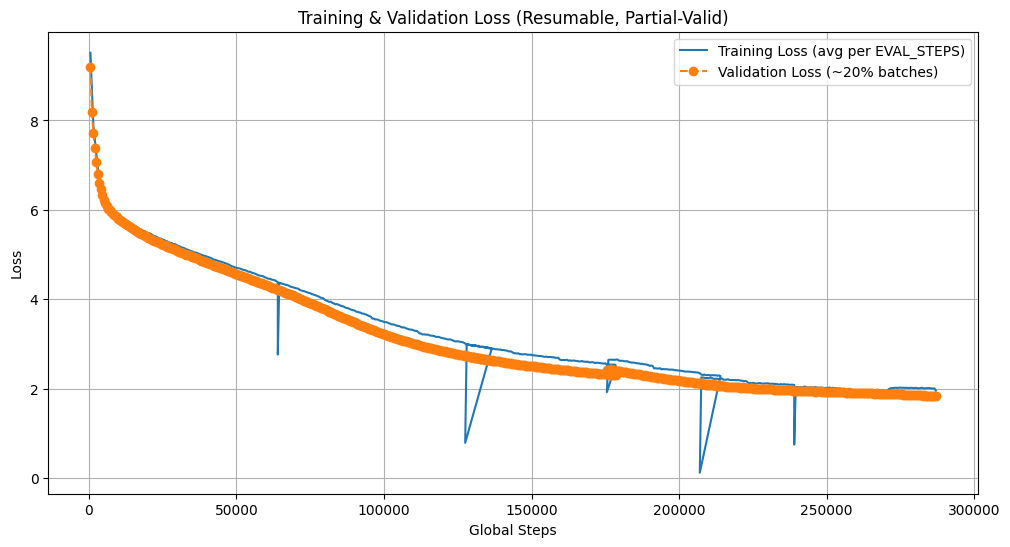

In [ ]:
# ===== 7) 손실 그래프 (이어붙이기 안전) =====
with open(HIST_PATH, "r", encoding="utf-8") as f:
    hist = json.load(f)

plt.figure(figsize=(12, 6))
if hist["train_steps"]:
    plt.plot(hist["train_steps"], hist["train_losses"], label='Training Loss (avg per EVAL_STEPS)')
if hist["val_steps"]:
    plt.plot(hist["val_steps"], hist["val_losses"], linestyle='--', marker='o',
             label=f'Validation Loss (~{int(VAL_FRACTION*100)}% batches)')
plt.title('Training & Validation Loss (Resumable, Partial-Valid)')
plt.xlabel('Global Steps'); plt.ylabel('Loss')
plt.legend(); plt.grid(True); plt.show()

# 3. 모델 테스트

In [ ]:
# ---------- 장치/토크나이저 ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sp = spm.SentencePieceProcessor(); sp.load(str(SPM_DIR/"spm.model"))
VOCAB_SIZE = sp.get_piece_size()

d_model, n_layers, n_head = 512, 6, 8
d_k = d_v = d_model // n_head
d_hid, dropout = 2048, 0.1
n_tokens = 100  # not critical at inference as long as >= max len

# You must have the Transformer class defined (from your training code).
# If it's in a module file, you can: from your_module import Transformer

model = Transformer(
    n_src_vocab=VOCAB_SIZE, n_tgt_vocab=VOCAB_SIZE, pad_idx=PAD_ID,
    d_word_vec=d_model, d_model=d_model, d_hid=d_hid, n_layers=n_layers,
    n_head=n_head, d_k=d_k, d_v=d_v, dropout=dropout, n_tokens=n_tokens,
    tgt_emb_prj_weight_sharing=True, emb_src_tgt_weight_sharing=True,
    scale_emb_or_prj="prj"
).to(device)
model.eval()

# pick best.pt if present, else latest.pt
ckpt_path = CKPT_DIR / ("best.pt" if (CKPT_DIR / "best.pt").exists() else "latest.pt")
assert ckpt_path.exists(), f"Checkpoint not found: {ckpt_path}"
state = torch.load(str(ckpt_path), map_location=device)
model.load_state_dict(state["model"])
print(f"Loaded checkpoint: {ckpt_path.name}, global_step={state.get('global_step','?')}")

Loaded checkpoint: best.pt, global_step=286578


In [ ]:
# ------- (5) Greedy decoding -------
@torch.no_grad()
def translate(text: str, max_len: int = 100, print_tokens: bool = True):
    """
    Because you trained a joint BPE (shared vocab), both directions work without tags,
    but quality may vary depending on training mixture.
    """
    # 1) Source encode (BOS/EOS added)
    src_ids = [BOS_ID] + sp_encode(text) + [EOS_ID]
    src = torch.tensor(src_ids, dtype=torch.long, device=device).unsqueeze(0)  # [1,S]
    S = src.size(1)

    # 2) Masks for encoder
    src_lens = torch.tensor([S], device=device)
    src_pad = make_padding_mask(src_lens, S, device=device)    # [1,S]
    src_mask = src_pad.unsqueeze(1).unsqueeze(2)               # [1,1,1,S]

    # 3) Start decoding with BOS
    tgt = torch.tensor([[BOS_ID]], dtype=torch.long, device=device)  # [1,1]

    for _ in range(max_len):
        T = tgt.size(1)
        # Build decoder masks per step
        tgt_pad = make_padding_mask(torch.tensor([T], device=device), T, device=device) # all False
        causal  = make_causal_mask(T, device=device)
        tgt_mask = (tgt_pad.unsqueeze(1).unsqueeze(2) | causal.unsqueeze(0).unsqueeze(1))  # [1,1,T,T]
        mem_mask = src_pad.unsqueeze(1).unsqueeze(2).expand(1,1,T,S)                       # [1,1,T,S]

        # Forward
        logits = model(src, tgt, src_mask, tgt_mask, mem_mask, return_attns=False)  # [1,T,V]
        next_token = int(logits[0, -1].argmax(dim=-1).item())

        # Append
        tgt = torch.cat([tgt, torch.tensor([[next_token]], device=device)], dim=1)

        if next_token == EOS_ID:
            break

    out_ids = tgt[0].tolist()  # [BOS, ..., EOS]
    # strip BOS/EOS and decode
    decoded = sp_decode(out_ids)
    if print_tokens:
        print(f"src: {text}")
        print(f"out_ids: {out_ids}")
    return decoded

# ------- (6) Quick smoke test -------
print("Ready. Example:")
# === Translation Test Sentences (for your model) ===

# === Translation Test Sentences (EN → KO) ===
print(translate("I woke up late because my alarm didn’t go off this morning."))
print(translate("The professor explained the algorithm in a way that was surprisingly easy to understand."))
print(translate("If it rains tomorrow, we might have to cancel the outdoor event."))
print(translate("Artificial intelligence is changing the way people learn and work."))
print(translate("I couldn’t decide whether to buy the laptop or wait for the new model."))
print(translate("She smiled as if she already knew the answer."))
print(translate("This project aims to improve energy efficiency in public schools."))
print(translate("The movie was much better than I expected, especially the ending."))
print(translate("Data security has become one of the most important issues in the digital age."))
print(translate("Don’t forget to back up your files before you reinstall the system."))



Ready. Example:
src: I woke up late because my alarm didn’t go off this morning.
out_ids: [1, 1852, 14398, 1613, 1182, 636, 4424, 14921, 12257, 9151, 15350, 829, 14900, 2]
오늘 아침에 농사가 안 내려서 늦게 일어났어요.
src: The professor explained the algorithm in a way that was surprisingly easy to understand.
out_ids: [1, 3450, 15335, 14925, 10871, 15056, 2883, 14911, 14565, 10286, 3817, 14946, 15574, 14910, 2876, 14900, 2]
교수님은 놀라운 이해가 쉬운 방법으로 알고리즘을 설명했다.
src: If it rains tomorrow, we might have to cancel the outdoor event.
out_ids: [1, 4541, 7497, 535, 14988, 12744, 6301, 3600, 4946, 1450, 868, 2652, 1234, 14900, 2]
내일 비가 오면 야외 이벤트를 취소해야 할 수도 있습니다.
src: Artificial intelligence is changing the way people learn and work.
out_ids: [1, 11196, 14904, 3677, 14462, 478, 390, 14322, 8223, 14917, 410, 14900, 2]
인공지능이 사람들이 배우고 일하는 방식을 바꾸고 있다.
src: I couldn’t decide whether to buy the laptop or wait for the new model.
out_ids: [1, 759, 15060, 15152, 14910, 3230, 13527, 10543, 2355, 4643, 14910, 4078, 15371, 1380